In [1]:
import pandas as pd
import numpy as np
import tabulate as tb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# DATASET

In [30]:
data = pd.read_csv('Dataset for linear regression.csv')
data.pop("Unnamed: 0")
data

#Remove Xmas dates
data = data[data['Xmas'] != 1.0]

#n=3305
data = data[data['DSN'] >= 0]


# Convert the 'Winter' column to string type
data['Winter'] = data['Winter'].astype(str)

# Extract the first year from the string and convert it to integer
data['Winter'] = data['Winter'].str.split('/').str[0].astype(int)

# Check the updated 'Winter' column
print(data['Winter'].head())


data['f_c'] = np.where(data['start_year'] < 2007, '0', '1')


# Add the squared term for DSN
data['DSN_sq'] = data['DSN']**2

1    1990
2    1990
3    1990
4    1990
5    1990
Name: Winter, dtype: int64


In [31]:
data.columns

Index(['demand_date', 'peak_demand', 'TO', 'TE', 'Winter', 'start_year',
       'Nov_date', 'DSN', 'DOW', 'DOW2', 'Xmas', 'Winter1', 'Winter2',
       'Winter3', 'Winter4', 'Winter5', 'Winter6', 'Winter7', 'Winter8',
       'Winter9', 'Winter10', 'Winter11', 'Winter12', 'Winter13', 'Winter14',
       'Winter15', 'Winter16', 'Winter17', 'Winter18', 'Winter19', 'Winter20',
       'Winter21', 'Winter22', 'Winter23', 'Winter24', 'Winter25', 'Winter26',
       'TEW1', 'TEW2', 'TEW3', 'TEW4', 'TEW5', 'TEW6', 'TEW7', 'TEW8', 'TEW9',
       'TEW10', 'TEW11', 'TEW12', 'TEW13', 'TEW14', 'TEW15', 'TEW16', 'TEW17',
       'TEW18', 'TEW19', 'TEW20', 'TEW21', 'TEW22', 'TEW23', 'TEW24', 'TEW25',
       'TEW26', 'f_c', 'DSN_sq'],
      dtype='object')

In [32]:
summary_wind = pd.read_csv("readings_at_6pm.csv")

summary_wind['time'] = pd.to_datetime(summary_wind['time'])

summary_wind['date'] = summary_wind['time'].dt.date
summary_wind.drop(columns=['time'], inplace=True)

summary_wind['date'] = pd.to_datetime(summary_wind['date'])


data['demand_date'] = pd.to_datetime(data['demand_date'])

In [38]:
merged_data = pd.merge(data, summary_wind, how='left', left_on='demand_date', right_on='date')

# Drop the extra datetime column (if it was added)
merged_data.drop(columns=['date','Unnamed: 0'], inplace=True, errors='ignore')



In [39]:
merged_data['DOW2'] = pd.Categorical(merged_data['DOW2'])

merged_data['DOW2'] = merged_data['DOW2'].cat.reorder_categories([7] + list(merged_data['DOW2'].cat.categories.difference([7])))


In [40]:
merged_data['DOW2']

0       4
1       5
2       6
3       7
4       1
       ..
3196    1
3197    2
3198    3
3199    4
3200    5
Name: DOW2, Length: 3201, dtype: category
Categories (7, int64): [7, 1, 2, 3, 4, 5, 6]

In [41]:
dow2_column = merged_data['DOW2']

# One-hot encode 'DOW2' column
data_encoded = pd.get_dummies(merged_data, columns=['DOW2'], prefix=['DOW2'])

# Concatenate the original 'DOW2' column with the one-hot encoded columns
merged_data = pd.concat([dow2_column, data_encoded], axis=1)

merged_data

,DOW2,demand_date,peak_demand,TO,TE,Winter,start_year,Nov_date,DSN,DOW,...,offshore (current + future),onshore (current),onshore (current + future),DOW2_7,DOW2_1,DOW2_2,DOW2_3,DOW2_4,DOW2_5,DOW2_6
0,4,1991-01-02,46861.0,6.624140,7.328970,1990,1990,1990-11-01,62,Wednesday,...,0.973978,0.808802,0.809469,0,0,0,0,1,0,0
1,5,1991-01-03,48295.5,5.403947,6.366459,1990,1990,1990-11-01,63,Thursday,...,0.944425,0.666188,0.667638,0,0,0,0,0,1,0
2,6,1991-01-04,47227.0,3.424677,4.895568,1990,1990,1990-11-01,64,Friday,...,0.964664,0.837248,0.839300,0,0,0,0,0,0,1
3,7,1991-01-05,42109.0,4.940087,4.917828,1990,1990,1990-11-01,65,Saturday,...,0.880028,0.813140,0.810174,1,0,0,0,0,0,0
4,1,1991-01-06,39458.5,4.187367,4.552597,1990,1990,1990-11-01,66,Sunday,...,0.891150,0.533717,0.538483,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1,2015-12-13,45497.5,5.388930,6.643740,2015,2015,2015-11-01,42,Sunday,...,0.267454,0.098855,0.098320,0,1,0,0,0,0,0
3197,2,2015-12-14,48426.5,6.964914,6.804327,2015,2015,2015-11-01,43,Monday,...,0.200488,0.152439,0.152522,0,0,1,0,0,0,0
3198,3,2015-12-15,48018.0,9.513962,8.159145,2015,2015,2015-11-01,44,Tuesday,...,0.891299,0.500198,0.500152,0,0,0,1,0,0,0
3199,4,2015-12-16,47622.0,11.423531,9.791338,2015,2015,2015-11-01,45,Wednesday,...,0.845028,0.318863,0.319897,0,0,0,0,1,0,0


In [42]:
merged_data

,DOW2,demand_date,peak_demand,TO,TE,Winter,start_year,Nov_date,DSN,DOW,...,offshore (current + future),onshore (current),onshore (current + future),DOW2_7,DOW2_1,DOW2_2,DOW2_3,DOW2_4,DOW2_5,DOW2_6
0,4,1991-01-02,46861.0,6.624140,7.328970,1990,1990,1990-11-01,62,Wednesday,...,0.973978,0.808802,0.809469,0,0,0,0,1,0,0
1,5,1991-01-03,48295.5,5.403947,6.366459,1990,1990,1990-11-01,63,Thursday,...,0.944425,0.666188,0.667638,0,0,0,0,0,1,0
2,6,1991-01-04,47227.0,3.424677,4.895568,1990,1990,1990-11-01,64,Friday,...,0.964664,0.837248,0.839300,0,0,0,0,0,0,1
3,7,1991-01-05,42109.0,4.940087,4.917828,1990,1990,1990-11-01,65,Saturday,...,0.880028,0.813140,0.810174,1,0,0,0,0,0,0
4,1,1991-01-06,39458.5,4.187367,4.552597,1990,1990,1990-11-01,66,Sunday,...,0.891150,0.533717,0.538483,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1,2015-12-13,45497.5,5.388930,6.643740,2015,2015,2015-11-01,42,Sunday,...,0.267454,0.098855,0.098320,0,1,0,0,0,0,0
3197,2,2015-12-14,48426.5,6.964914,6.804327,2015,2015,2015-11-01,43,Monday,...,0.200488,0.152439,0.152522,0,0,1,0,0,0,0
3198,3,2015-12-15,48018.0,9.513962,8.159145,2015,2015,2015-11-01,44,Tuesday,...,0.891299,0.500198,0.500152,0,0,0,1,0,0,0
3199,4,2015-12-16,47622.0,11.423531,9.791338,2015,2015,2015-11-01,45,Wednesday,...,0.845028,0.318863,0.319897,0,0,0,0,1,0,0


In [43]:
merged_data['date_int'] = (merged_data['demand_date'] - merged_data['demand_date'].iloc[0]).dt.days + 1

merged_data['date_int_squared'] = merged_data['date_int']**2


# Calculate interaction term TE:date_int
merged_data['TE:date_int'] = merged_data['TE'] * merged_data['date_int']

# Calculate interaction term TE:I(date_int^2)
merged_data['TE:I(date_int^2)'] = merged_data['TE'] * (merged_data['date_int']**2)

# Winter encoding
data['Winter'] = data['Winter'].astype('category')



In [44]:
merged_df= merged_data 
data_2004 = merged_df[merged_df['start_year'] == 2005].reset_index(drop=True)
data_2004.columns

Index(['DOW2', 'demand_date', 'peak_demand', 'TO', 'TE', 'Winter',
       'start_year', 'Nov_date', 'DSN', 'DOW', 'Xmas', 'Winter1', 'Winter2',
       'Winter3', 'Winter4', 'Winter5', 'Winter6', 'Winter7', 'Winter8',
       'Winter9', 'Winter10', 'Winter11', 'Winter12', 'Winter13', 'Winter14',
       'Winter15', 'Winter16', 'Winter17', 'Winter18', 'Winter19', 'Winter20',
       'Winter21', 'Winter22', 'Winter23', 'Winter24', 'Winter25', 'Winter26',
       'TEW1', 'TEW2', 'TEW3', 'TEW4', 'TEW5', 'TEW6', 'TEW7', 'TEW8', 'TEW9',
       'TEW10', 'TEW11', 'TEW12', 'TEW13', 'TEW14', 'TEW15', 'TEW16', 'TEW17',
       'TEW18', 'TEW19', 'TEW20', 'TEW21', 'TEW22', 'TEW23', 'TEW24', 'TEW25',
       'TEW26', 'f_c', 'DSN_sq', 'temp_GB', 'pop_temp (UK)',
       'offshore (current)', 'offshore (current + future)',
       'onshore (current)', 'onshore (current + future)', 'DOW2_7', 'DOW2_1',
       'DOW2_2', 'DOW2_3', 'DOW2_4', 'DOW2_5', 'DOW2_6', 'date_int',
       'date_int_squared', 'TE:date_int', 

# Regression Training

In [45]:
X = merged_df[[ 'DSN', 'DSN_sq','Winter1', 'Winter2','Winter3', 'Winter4', 'Winter5', 'Winter6', 'Winter7', 
                'Winter8','Winter9', 'Winter10', 'Winter11', 'Winter12', 'Winter13', 'Winter14','Winter15', 
                'Winter16', 'Winter17', 'Winter18', 'Winter19', 'Winter20','Winter21', 'Winter22', 'Winter23',
                'Winter24','Winter25', 'Winter26','DOW2_7', 'DOW2_1', 'DOW2_2', 'DOW2_3','DOW2_4', 'DOW2_5', 
                'DOW2_6', 'TEW1', 'TEW2', 'TEW3', 'TEW4', 'TEW5', 'TEW6', 'TEW7', 'TEW8', 'TEW9','TEW10', 'TEW11',
                'TEW12', 'TEW13', 'TEW14', 'TEW15', 'TEW16', 'TEW17','TEW18', 'TEW19', 'TEW20', 'TEW21', 'TEW22', 
                'TEW23', 'TEW24', 'TEW25','TEW26']]

X = sm.add_constant(X)

y = merged_df['peak_demand']

model = sm.OLS(y, X).fit()

print(model.summary())

# Calculate AIC
aic = model.aic

# Print AIC
print(f"AIC: {aic}")

                            OLS Regression Results                            
Dep. Variable:            peak_demand   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1756.
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:18:02   Log-Likelihood:                -25981.
No. Observations:                3201   AIC:                         5.208e+04
Df Residuals:                    3141   BIC:                         5.245e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.413e+04     62.421    706.916      0.0

# Shift Function

In [113]:
def encode_dow_columns(df):
    for i in range(1, 8):
        col_name = f'DOW2_{i}'
        df[col_name] = (df['DOW2'] == i).astype(int)
    return df

    
def update_DOW(df):
    dow_mapping = {
        1: 'Sunday',
        2: 'Monday',
        3: 'Tuesday',
        4: 'Wednesday',
        5: 'Thursday',
        6: 'Friday',
        7: 'Saturday'
    }
    df['DOW'] = df['DOW2'].map(dow_mapping)
    return df  



def Shift_wheatcroft(winter_df, shift_days=1):
    
    hold = winter_df['DSN'].iloc[0]
    winter_df['DSN'] = winter_df['DSN'].shift(-1)
    winter_df['DSN'].iloc[-1] = int(hold)
    
    winter_df['DSN_sq'] = winter_df['DSN']**2
    
    hold = winter_df['DOW2'].iloc[0]
    winter_df['DOW2'] = winter_df['DOW2'].shift(-1)
    winter_df['DOW2'].iloc[-1] = int(hold)
        
    winter_df = encode_dow_columns(winter_df)
    
    
    winter_df = update_DOW(winter_df)
 
    
    X = winter_df[['DSN', 'DSN_sq','Winter1', 'Winter2','Winter3', 'Winter4', 'Winter5', 'Winter6', 'Winter7', 
                'Winter8','Winter9', 'Winter10', 'Winter11', 'Winter12', 'Winter13', 'Winter14','Winter15', 
                'Winter16', 'Winter17', 'Winter18', 'Winter19', 'Winter20','Winter21', 'Winter22', 'Winter23',
                'Winter24','Winter25', 'Winter26','DOW2_7', 'DOW2_1', 'DOW2_2', 'DOW2_3','DOW2_4', 'DOW2_5', 
                'DOW2_6', 'TEW1', 'TEW2', 'TEW3', 'TEW4', 'TEW5', 'TEW6', 'TEW7', 'TEW8', 'TEW9','TEW10', 'TEW11',
                'TEW12', 'TEW13', 'TEW14', 'TEW15', 'TEW16', 'TEW17','TEW18', 'TEW19', 'TEW20', 'TEW21', 'TEW22', 
                'TEW23', 'TEW24', 'TEW25','TEW26']]
    
    X = sm.add_constant(X, has_constant= 'add')
  
    winter_df['peak_demand'] = model.predict(X)
    
    #rescale demand
    winter_df['peak_demand'] = winter_df['peak_demand']/1.0021471739877368
    
        

    
    return winter_df

1.0004495194013399

In [47]:
merged_df.columns

Index(['DOW2', 'demand_date', 'peak_demand', 'TO', 'TE', 'Winter',
       'start_year', 'Nov_date', 'DSN', 'DOW', 'Xmas', 'Winter1', 'Winter2',
       'Winter3', 'Winter4', 'Winter5', 'Winter6', 'Winter7', 'Winter8',
       'Winter9', 'Winter10', 'Winter11', 'Winter12', 'Winter13', 'Winter14',
       'Winter15', 'Winter16', 'Winter17', 'Winter18', 'Winter19', 'Winter20',
       'Winter21', 'Winter22', 'Winter23', 'Winter24', 'Winter25', 'Winter26',
       'TEW1', 'TEW2', 'TEW3', 'TEW4', 'TEW5', 'TEW6', 'TEW7', 'TEW8', 'TEW9',
       'TEW10', 'TEW11', 'TEW12', 'TEW13', 'TEW14', 'TEW15', 'TEW16', 'TEW17',
       'TEW18', 'TEW19', 'TEW20', 'TEW21', 'TEW22', 'TEW23', 'TEW24', 'TEW25',
       'TEW26', 'f_c', 'DSN_sq', 'temp_GB', 'pop_temp (UK)',
       'offshore (current)', 'offshore (current + future)',
       'onshore (current)', 'onshore (current + future)', 'DOW2_7', 'DOW2_1',
       'DOW2_2', 'DOW2_3', 'DOW2_4', 'DOW2_5', 'DOW2_6', 'date_int',
       'date_int_squared', 'TE:date_int', 

In [48]:
data_2004 = merged_df[merged_df['start_year'] == 2005].reset_index(drop=True)
data_2004

,DOW2,demand_date,peak_demand,TO,TE,Winter,start_year,Nov_date,DSN,DOW,...,DOW2_1,DOW2_2,DOW2_3,DOW2_4,DOW2_5,DOW2_6,date_int,date_int_squared,TE:date_int,TE:I(date_int^2)
0,3,2005-11-01,52478.0,9.601715,11.538631,2005,2005,2005-11-01,0,Tuesday,...,0,0,1,0,0,0,5418,29354724,62516.300729,3.387133e+08
1,4,2005-11-02,52810.5,14.930636,13.234633,2005,2005,2005-11-01,1,Wednesday,...,0,0,0,1,0,0,5419,29365561,71718.477299,3.886424e+08
2,5,2005-11-03,52259.5,12.909579,13.072106,2005,2005,2005-11-01,2,Thursday,...,0,0,0,0,1,0,5420,29376400,70850.816045,3.840114e+08
3,6,2005-11-04,50840.5,8.680171,10.876139,2005,2005,2005-11-01,3,Friday,...,0,0,0,0,0,1,5421,29387241,58959.548253,3.196197e+08
4,7,2005-11-05,46820.5,11.566497,11.221318,2005,2005,2005-11-01,4,Saturday,...,0,0,0,0,0,0,5422,29398084,60841.985231,3.298852e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,3,2006-03-21,54476.5,3.118200,3.992563,2005,2005,2005-11-01,140,Tuesday,...,0,0,1,0,0,0,5558,30891364,22190.662870,1.233357e+08
125,4,2006-03-22,53936.0,3.588911,3.790737,2005,2005,2005-11-01,141,Wednesday,...,0,0,0,1,0,0,5559,30902481,21072.704725,1.171432e+08
126,5,2006-03-23,52526.5,5.879438,4.835087,2005,2005,2005-11-01,142,Thursday,...,0,0,0,0,1,0,5560,30913600,26883.085293,1.494700e+08
127,6,2006-03-24,49785.5,9.051418,6.943253,2005,2005,2005-11-01,143,Friday,...,0,0,0,0,0,1,5561,30924721,38611.427662,2.147181e+08


In [49]:
Shift_wheatcroft(data_2004)

,DOW2,demand_date,peak_demand,TO,TE,Winter,start_year,Nov_date,DSN,DOW,...,DOW2_1,DOW2_2,DOW2_3,DOW2_4,DOW2_5,DOW2_6,date_int,date_int_squared,TE:date_int,TE:I(date_int^2)
0,4,2005-11-01,49960.249342,9.601715,11.538631,2005,2005,2005-11-01,1.0,Wednesday,...,0,0,0,1,0,0,5418,29354724,62516.300729,3.387133e+08
1,5,2005-11-02,48986.777983,14.930636,13.234633,2005,2005,2005-11-01,2.0,Thursday,...,0,0,0,0,1,0,5419,29365561,71718.477299,3.886424e+08
2,6,2005-11-03,47698.303305,12.909579,13.072106,2005,2005,2005-11-01,3.0,Friday,...,0,0,0,0,0,1,5420,29376400,70850.816045,3.840114e+08
3,7,2005-11-04,44168.045611,8.680171,10.876139,2005,2005,2005-11-01,4.0,Saturday,...,0,0,0,0,0,0,5421,29387241,58959.548253,3.196197e+08
4,1,2005-11-05,43415.835504,11.566497,11.221318,2005,2005,2005-11-01,5.0,Sunday,...,1,0,0,0,0,0,5422,29398084,60841.985231,3.298852e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,4,2006-03-21,50387.858248,3.118200,3.992563,2005,2005,2005-11-01,141.0,Wednesday,...,0,0,0,1,0,0,5558,30891364,22190.662870,1.233357e+08
125,5,2006-03-22,50194.324192,3.588911,3.790737,2005,2005,2005-11-01,142.0,Thursday,...,0,0,0,0,1,0,5559,30902481,21072.704725,1.171432e+08
126,6,2006-03-23,48176.321106,5.879438,4.835087,2005,2005,2005-11-01,143.0,Friday,...,0,0,0,0,0,1,5560,30913600,26883.085293,1.494700e+08
127,7,2006-03-24,42410.691845,9.051418,6.943253,2005,2005,2005-11-01,144.0,Saturday,...,0,0,0,0,0,0,5561,30924721,38611.427662,2.147181e+08


# Calculations for Normalisation

In [100]:
all_demand = np.array([])
all_WIND = np.array([])
years = 0

In [106]:
for year in range(1990, 2017):
    data_plot = merged_df[merged_df['start_year'] == year]
    data_plot.reset_index(drop=True, inplace=True)

    i = 0
    
    while i < len(data_plot):
        Shift_wheatcroft(data_plot)
        all_demand = np.append(all_demand,data_plot['peak_demand'])
        all_WIND = np.append(all_WIND,data_plot['offshore (current + future)'])
        years = years + 1
        i = i + 1


In [107]:
from scipy.stats import norm
conv = pd.read_csv("GB_anonymised_conv.txt", sep=' ')

conv["E(x)"]= conv["Capacity"]*conv["Availability"]
conv['Var'] = conv['Availability']*(1-conv['Availability'])*conv['Capacity']*conv['Capacity']
Ex = conv.sum()[3]
Var = conv.sum()[4]

def LOLE(years,D,VG):
    D_VG = D - VG 
    
    total = 0
    for i in  D_VG:
        total = total + norm.cdf(i, Ex, np.sqrt(Var))
    
    return total/years

In [112]:
from scipy.optimize import minimize_scalar

def opt(alpha):
    return LOLE(years, all_demand/alpha, 15*1000*all_WIND)
    
def objective_function(alpha):
    return abs(opt(alpha) - 4.822049574458154)
    

# Find the value of alpha that minimizes the objective function
result = minimize_scalar(objective_function,bounds=(1, 1.2), tol=0.0001)

print("Optimal alpha:", result.x)
print("Function value at optimal alpha:", opt(result.x))

/Users/ninaginny/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Optimal alpha: 1.0021471739877368
Function value at optimal alpha: 4.823428377059114


# Plots for report

In [ ]:
data_plot = merged_df[merged_df['start_year'] == 2005]
Shift_wheatcroft(data_plot)

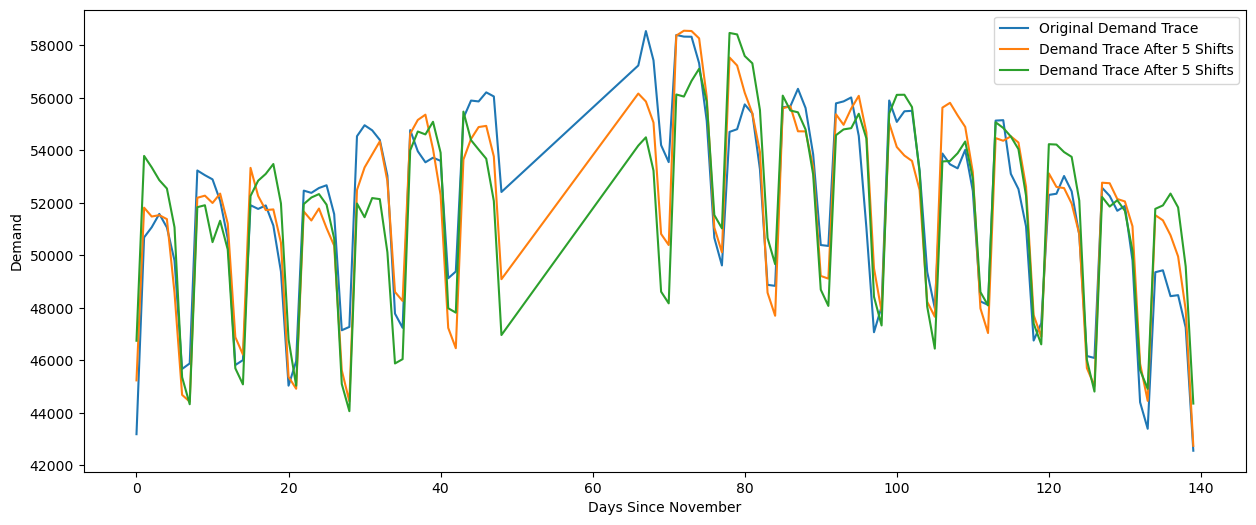

In [116]:
merged_df= merged_data 

# Sample data
import matplotlib.pyplot as plt
data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)

data_2004.reset_index(drop=True, inplace=True)

data_2004_orig = data_2004.copy()

# Define the number of shifts
shifts_to_plot = [5,10]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(data_2004_orig['DSN'],data_2004_orig['peak_demand'], label='Original Demand Trace')


j = 0
while j < shifts_to_plot[0]: 
    Shift_wheatcroft(data_2004_orig)
    j = j +1 

data_2004_orig = data_2004_orig.sort_values(by='DSN')
    
plt.plot(data_2004_orig['DSN'], data_2004_orig['peak_demand'], label=f'Demand Trace After {shifts_to_plot[0]} Shifts')    
   
data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)
data_2004.reset_index(drop=True, inplace=True)

data_2004_orig = data_2004.copy()

j = 0
while j < shifts_to_plot[1]: 
    Shift_wheatcroft(data_2004_orig)
    j = j +1 
    
data_2004_orig = data_2004_orig.sort_values(by='DSN')
plt.plot(data_2004_orig['DSN'], data_2004_orig['peak_demand'], label=f'Demand Trace After {shifts_to_plot[0]} Shifts')        
data_2004_orig.to_csv('wheatcroft_now.csv', index=False)
  
    
    
plt.xlabel('Days Since November')
plt.ylabel('Demand')
plt.legend()
plt.show()

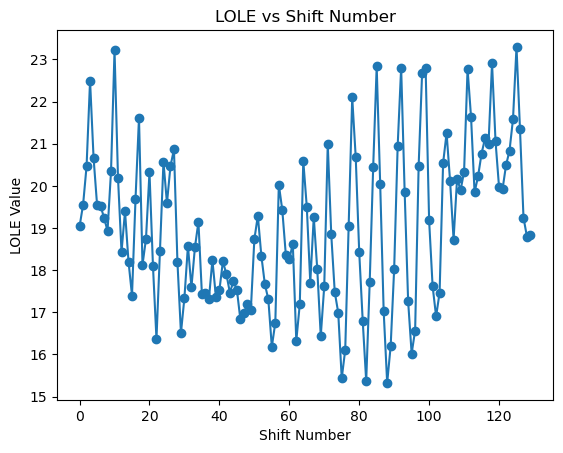

In [120]:
# 2009
import matplotlib.pyplot as plt
data_plot = merged_df[merged_df['start_year'] == 2005]

# Number of shifts you want to perform
num_shifts = len(data_plot)

# Lists to store results for plotting
shift_numbers = []
LOLE_values = []

# Initial LOLE calculation
# Initial LOLE calculation
current_LOLE = LOLE(1, data_plot['peak_demand'], 15*1000 * data_plot['offshore (current + future)'])
shift_numbers.append(0)
LOLE_values.append(current_LOLE)

# Perform shifts and calculate LOLE for each shift
for shift_number in range(1, num_shifts + 1):
    # Shift the data
    data_plot = Shift_wheatcroft(data_plot)
    
    # Calculate LOLE for the shifted data
    current_LOLE = LOLE(1, data_plot['peak_demand'], 15*1000 * data_plot['offshore (current + future)'])
    
    # Append results to lists
    shift_numbers.append(shift_number)
    LOLE_values.append(current_LOLE)

# Plot the results
plt.plot(shift_numbers, LOLE_values, marker='o')

rel = {'shift_numbers': shift_numbers, 'LOLE_values': LOLE_values}
df = pd.DataFrame(rel)

# Save the DataFrame to a CSV file
df.to_csv('urgent_2.csv', index=False)


plt.xlabel('Shift Number')
plt.ylabel('LOLE Value')
plt.title('LOLE vs Shift Number')
plt.show()

In [ ]:
# Sample data
import matplotlib.pyplot as plt
data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)
data_2004.reset_index(drop=True, inplace=True)
data_2004_orig = data_2004.copy()

# Define the number of shifts
shifts_to_plot = [5, 10]
def print_average_demand(data):
    average_demand = data['peak_demand'].mean()
    print(f"Average Demand: {average_demand:.2f}")



# Plotting
plt.figure(figsize=(15, 6))
plt.plot(data_2004_orig['peak_demand'], label='Original Demand Trace')
print_average_demand(data_2004_orig)



def plot_and_print_shifts(shifts):
    for shift in shifts:
        data_shifted = data_2004_orig.copy()
        for _ in range(shift):
            Shift_wheatcroft(data_shifted)
        plt.plot(data_shifted['peak_demand'], label=f'Demand Trace After {shift} Shifts')
        print_average_demand(data_shifted)


plot_and_print_shifts(shifts_to_plot)

plt.xlabel('Days Since November')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)
data_2004.reset_index(drop=True, inplace=True)
data_2004_orig = data_2004.copy()

# Define the number of shifts
shifts_to_plot = [5, 10]

def print_average_demand(data):
    average_demand = data['peak_demand'].mean()
    print(f"Average Demand: {average_demand:.2f}")

def plot_and_print_shifts(shifts, filename):
    df_list = [data_2004_orig.copy()]
    labels = ['Original']
    for shift in shifts:
        data_shifted = data_2004_orig.copy()
        for _ in range(shift):
            Shift_wheatcroft(data_shifted)
        df_list.append(data_shifted)
        labels.append(f'{shift} Shifts')
        print_average_demand(data_shifted)

    # Plotting
    plt.figure(figsize=(15, 6))
    for df, label in zip(df_list, labels):
        plt.plot(df['peak_demand'], label=label)
    plt.xlabel('Days Since November')
    plt.ylabel('Demand')
    plt.legend()
    plt.savefig(filename + '.png')
    plt.show()

    # Exporting to CSV
    for i, df in enumerate(df_list):
        df.to_csv(f'{filename}_{labels[i]}.csv', index=False)

plot_and_print_shifts(shifts_to_plot, 'demand_data')


MovieWriter ffmpeg unavailable; using Pillow instead.


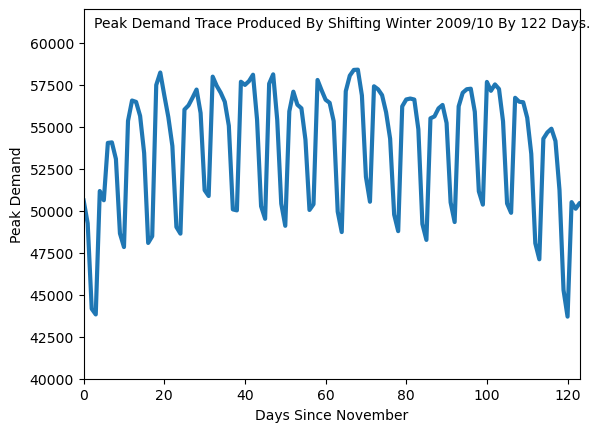

In [67]:
from matplotlib import pyplot as plt 
import numpy as np 
from matplotlib.animation import FuncAnimation  

# initializing a figure in  
# which the graph will be plotted 
fig = plt.figure()  

# marking the x-axis and y-axis 
axis = plt.axes(xlim =(0, 123),  
                ylim =(40000, 62000))  

# initializing a line variable 
line, = axis.plot([], [], lw = 3)  

# initializing text for caption
text = axis.text(0.02, 0.95, '', transform=axis.transAxes)

# Set axis labels
plt.xlabel('Days Since November')
plt.ylabel('Peak Demand')

# data which the line will  
# contain (x, y) 
def init():  
    line.set_data([], []) 
    text.set_text('')
    return line, text

def animate(i):
    data_plot = merged_df[merged_df['start_year'] == 2004]
    
    # Shift the data i times
    for _ in range(i):
        Shift_wheatcroft(data_plot)
    
    x = np.arange(len(data_plot))
    y = data_plot['peak_demand']
   
    line.set_data(x, y)
    text.set_text(f'Peak Demand Trace Produced By Shifting Winter 2009/10 By {i} Days.')
      
    return line, text

anim = FuncAnimation(fig, animate, init_func=init, 
                     frames=123, interval=1, blit=True) 

anim.save('200.gif', writer='ffmpeg', fps=10)
